## Untuk menguji coba versi keras yang digunakan

In [1]:
from keras import __version__ as v
from keras import backend as K

print('Menggunakan Keras Versi ' + str(v))
print('Backend ' + str(K.backend().title()))

Using TensorFlow backend.


Menggunakan Keras Versi 2.0.2
Backend Tensorflow


## Menggunakan MNIST dengan variasi layer konvolusi

MNIST adalah dataset angka dari 0 hingga 9 yang dikenal sebagai "Hello World" untuk *image processing*. Terdiri dari 60000 training example dan 10000 testing example. Dataset terdiri dari x berupa gambar dan y label dari gambar tersebut. Dataset secara resmi dapat di download di http://yann.lecun.com/exdb/mnist/.

In [2]:
from keras.datasets import mnist
(trainData, trainLabels), (testData, testLabels) = mnist.load_data()

## Konfigurasi Umum

In the neural network terminology:

* one **epoch** = one forward pass and one backward pass of all the training examples. Nilai epochs yang kecil akan membuat hasil underfitting, ketika terlalu besar maka hanya mengingat dari dataset training saja.
* **batch size** = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need. Typically networks trains faster with mini-batches. That's because we update weights after each propagation.  If we used all samples during propagation we would make only 1 update for the network's parameter.
* **number of iterations** = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

* **num_classes** merupakan banyaknya kelas yang diprediksi. Nilainya berdasarkan keluaran dari *inner product*.

* **img_rows, img_cols** merupakan width dan height dari dataset yang digunakan.

In [3]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

## Konfigurasi Dataset
Dataset MNIST dilakukan penyesuaian dimana ukuran dirubah berdasarkan *image dimensions* yang telah kita tentukan sebelumnya. Angka 1 mengindikasikan gambar hanya tersedia dalam 1 channel atau grayscale.

**Nb**: Penulisan channel untuk tensorflow berada di belakang.

Selanjutnya, perubahan nilai grayscale menggunakan skala 0-1 dari sebelumnya 0-255. Karena sekarang menggunakan python2, agar mendapatkan nilai float maka harus dibagi dengan nilai float juga.

In [4]:
if K.image_data_format() == 'channels_first': # Theano
    trainData = trainData.reshape(trainData.shape[0], 1, img_rows, img_cols)
    testData = testData.reshape(testData.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # Tensorflow
    trainData = trainData.reshape(trainData.shape[0], img_rows, img_cols, 1)
    testData = testData.reshape(testData.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

trainData = trainData.astype('float32')
testData = testData.astype('float32')
trainData /= 255.0 # Merubah scaling 0 - 255 menjadi 0 - 1.0
testData /= 255.0

print('trainData shape:', trainData.shape)
print(trainData.shape[0], 'train samples')
print(testData.shape[0], 'test samples')

# convert class vectors to binary class matrices
trainLabels = keras.utils.to_categorical(trainLabels, num_classes)
testLabels = keras.utils.to_categorical(testLabels, num_classes)

('trainData shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


## Struktur data sekuensial dengan **model**
The core data structure of Keras is a model, a way to organize layers. The simplest type of model is the Sequential model, a linear stack of layers. For more complex architectures, you should use the [Keras functional API](http://keras.io/getting-started/functional-api-guide), which allows to build arbitrary graphs of layers.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

## Beberapa opsi untuk layer

### *[Core Layer](https://keras.io/layers/core/)*

#### Dense (Fully connected / inner product)
Untuk menggabungkan semua neuron dan melakukan klasifikasi (pada layer terakhir). Output merupakan banyaknya kelas yang dapat di klasifikasi.

*keras.layers.core.Dense(**units**, **activation**=None, **use_bias**=True, **kernel_initializer**='glorot_uniform', **bias_initializer**='zeros', **kernel_regularizer**=None, **bias_regularizer**=None, **activity_regularizer**=None, **kernel_constraint**=None, **bias_constraint**=None)*

#### Dropout
Mencegah overfitting berdasarkan rate yang diberikan.

*keras.layers.core.Dropout(**rate**, **noise_shape**=None, **seed**=None)*

#### Flatten
Untuk menggabungkan image shape menjadi vector (matriks 1 dimensi).

*keras.layers.core.Flatten()*


### *[Convolution Layer](https://keras.io/layers/convolutional)*

#### Conv2D
Konvolusi untuk matriks 2D seperti gambar. Opsi yang harus ditentukan adalah filters (output) dan kernel_size (dan input_shape jika menjadi layer pertama).

*keras.layers.convolutional.Conv2D(**filters**, **kernel_size**, **strides**=(1, 1), **padding**='valid', **data_format**=None, **dilation_rate**=(1, 1), **activation**=None, **use_bias**=True, **kernel_initializer**='glorot_uniform', **bias_initializer**='zeros', **kernel_regularizer**=None, **bias_regularizer**=None, **activity_regularizer**=None, **kernel_constraint**=None, **bias_constraint**=None)*

### *[Pooling Layer](https://keras.io/layers/pooling)*

#### MaxPooling2D
Pooling untuk matriks 2D

*keras.layers.pooling.MaxPooling2D(**pool_size**=(2, 2), **strides**=None, **padding**='valid', **data_format**=None)*

---
**Nb**: [Apa bedanya **strides** dan **padding**]( https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/)

## Konfigurasi model

Once your model looks good, configure its learning process with **.compile()**. 

*compile(self, **optimizer**, **loss**, **metrics**=None, **sample_weight_mode**=None)*

Argumen yang diberikan adalah [loss](https://keras.io/losses/) dan [optimizer](https://keras.io/optimizers/)

Kita juga bisa melihat rangkuman dari model yang kita buat dengan **.summary()**.

In [6]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Compile dengan konfigurasi lebih banyak
# model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

### Learning

Learning dilakukan dengan **.fit()**

*fit(self, **x**, **y**, **batch_size**=32, **epochs**=10, **verbose**=1, **callbacks**=None, **validation_split**=0.0, **validation_data**=None, **shuffle**=True, **class_weight**=None, **sample_weight**=None, **initial_epoch**=0)*

Untuk mengujinya, bisa dengan **.evaluate**

In [7]:
model.fit(trainData, trainLabels,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(testData, testLabels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 4s - loss: 0.3312 - acc: 0.9003 - val_loss: 0.0786 - val_acc: 0.9765
Epoch 2/12
60000/60000 [==============================] - 4s - loss: 0.1127 - acc: 0.9659 - val_loss: 0.0533 - val_acc: 0.9815
Epoch 3/12
60000/60000 [==============================] - 4s - loss: 0.0859 - acc: 0.9752 - val_loss: 0.0440 - val_acc: 0.9856
Epoch 4/12
60000/60000 [==============================] - 5s - loss: 0.0735 - acc: 0.9784 - val_loss: 0.0394 - val_acc: 0.9860
Epoch 5/12
60000/60000 [==============================] - 4s - loss: 0.0628 - acc: 0.9817 - val_loss: 0.0343 - val_acc: 0.9881
Epoch 6/12
60000/60000 [==============================] - 4s - loss: 0.0562 - acc: 0.9833 - val_loss: 0.0335 - val_acc: 0.9888
Epoch 7/12
60000/60000 [==============================] - 4s - loss: 0.0496 - acc: 0.9851 - val_loss: 0.0299 - val_acc: 0.9904
Epoch 8/12
60000/60000 [==============================] - 4s 

In [8]:
(loss, accuracy) = model.evaluate(testData, testLabels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

('Test loss:', 0.029404803463989812)
('Test accuracy:', 0.99050000000000005)


### Predicting

[[  1.22495516e-14   5.85485480e-11   2.54987502e-12   3.67812470e-14
    1.00000000e+00   3.77313659e-13   2.12524946e-11   3.41088990e-10
    1.05070709e-11   6.24187679e-09]]


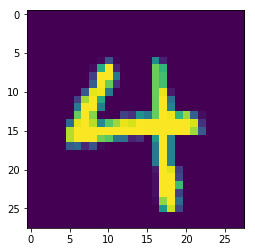

[INFO] Predicted:4, Actual: 4
[[  8.49127355e-13   6.23464752e-11   2.87939169e-11   8.19448350e-13
    9.99999881e-01   6.47434783e-14   3.60048406e-12   7.23474891e-10
    1.44380979e-10   5.96990688e-08]]


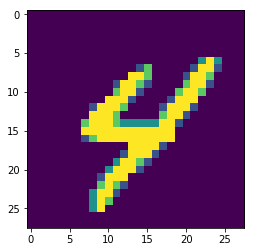

[INFO] Predicted:4, Actual: 4
[[  2.81239032e-09   9.99998927e-01   3.88097838e-08   9.99616723e-10
    8.16241368e-07   5.00870545e-09   2.17622205e-08   1.20945330e-07
    1.55278901e-08   1.92420790e-09]]


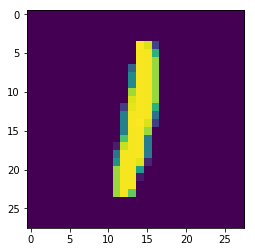

[INFO] Predicted:1, Actual: 1
[[  8.79393058e-10   9.99998450e-01   5.42947873e-08   8.16919155e-09
    8.14740758e-07   2.38823694e-09   2.64099871e-08   5.65243738e-07
    2.00578114e-08   1.93145810e-09]]


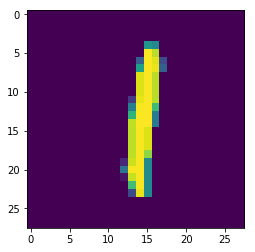

[INFO] Predicted:1, Actual: 1
[[  3.70306865e-04   1.91663191e-01   6.67817950e-01   1.29232099e-02
    7.63981589e-05   4.25159931e-04   8.29793680e-06   5.57032065e-04
    1.25397146e-01   7.61351839e-04]]


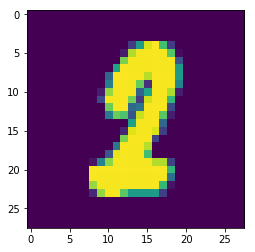

[INFO] Predicted:2, Actual: 2
[[  4.13134506e-13   6.59385662e-16   1.02976451e-17   6.19164234e-11
    5.94992805e-14   1.00000000e+00   1.51508008e-11   2.69767331e-15
    5.27470862e-12   9.27007970e-10]]


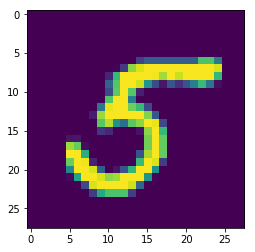

[INFO] Predicted:5, Actual: 5
[[  1.22740539e-06   1.90558480e-09   2.41552889e-09   1.33074025e-07
    3.44698527e-08   1.26351218e-03   9.98722017e-01   3.76814080e-10
    1.27346993e-05   3.33501958e-07]]


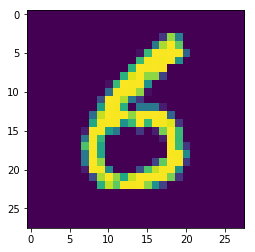

[INFO] Predicted:6, Actual: 6
[[  4.06615019e-11   5.88175642e-09   6.04486488e-08   1.21267281e-08
    1.35631825e-10   4.83102653e-13   1.73953584e-13   9.99999881e-01
    5.59216701e-11   1.06845661e-08]]


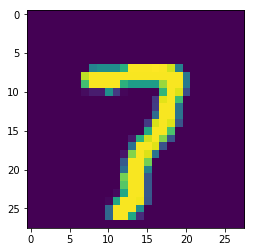

[INFO] Predicted:7, Actual: 7
[[  8.77503282e-07   6.88051449e-10   9.08712323e-08   7.02406098e-08
    1.83346245e-07   5.76901698e-07   6.03724093e-09   2.74399395e-06
    2.30376870e-07   9.99995232e-01]]


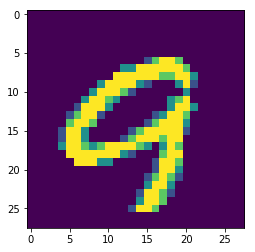

[INFO] Predicted:9, Actual: 9
[[  5.68821899e-12   1.51777421e-13   8.53474972e-15   1.14115528e-09
    6.35407560e-11   1.00000000e+00   5.84855409e-09   5.70862801e-13
    9.97751570e-09   2.81764456e-09]]


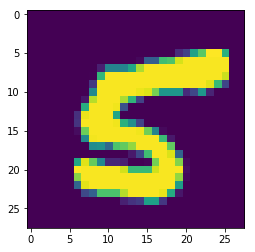

[INFO] Predicted:5, Actual: 5


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import keras.preprocessing.image as image

for i in np.random.choice(np.arange(0, len(testLabels)), size=(10,)):
    # classify the digit
    probs = model.predict(testData[np.newaxis, i])
    print(probs)
    prediction = probs.argmax(axis=1)
    
    # resize the image from a 28 x 28 image to a 96 x 96 image so we
    # can better see it
    img = image.array_to_img(testData[i] * 255)
    plt.imshow(img)
    plt.show()
    # show the image and prediction
    print("[INFO] Predicted:" + str(prediction[0]) + ", Actual: " + str(np.argmax(testLabels[i])))